1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [1]:
# Necssary libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.basemap import Basemap
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random

/Users/tian/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:

df =pd.read_csv("https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv",index_col=0)
df.head()



,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [4]:
df_default=pd.get_dummies(df['default'])
df_student=pd.get_dummies(df['student'])
df['default'] = df['default'].replace('No', 'default_No').replace('Yes', 'default_Yes')
df['student'] = df['student'].replace('No', 'student_No').replace('Yes', 'student_Yes')
df_final = pd.concat([df[['balance','income']],df_default, df_student],axis=1)
df_final.head()

,balance,income,default_No,default_Yes,student_No,student_Yes
1,729.526495,44361.625074,1.0,0.0,1.0,0.0
2,817.180407,12106.134700,1.0,0.0,0.0,1.0
3,1073.549164,31767.138947,1.0,0.0,1.0,0.0
4,529.250605,35704.493935,1.0,0.0,1.0,0.0
5,785.655883,38463.495879,1.0,0.0,1.0,0.0


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

<function matplotlib.pyplot.show>

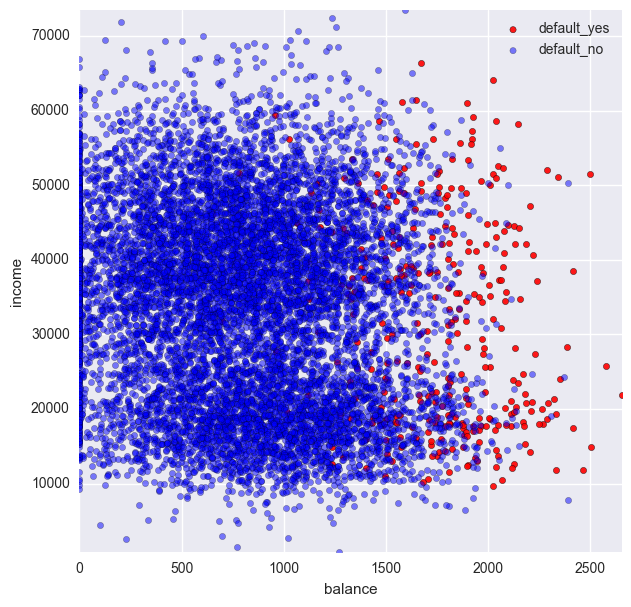

In [5]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=(7,7))

df_y = df_final[df_final.default_Yes==1]
df_n = df_final[df_final.default_Yes==0]

# scatter plot of balance (x) and income (y)
cm_bright = ListedColormap(['#FF0000','#0000FF'])
plt.scatter(x=df_y['balance'], y=df_y['income'], c='r', label='default_yes', alpha=0.9)
plt.scatter(x=df_n['balance'], y=df_n['income'], c='b', label='default_no', alpha=0.5)        
plt.xlim((df.balance.min(), df.balance.max()))
plt.ylim((df.income.min(), df.income.max()))
plt.xlabel('balance')
plt.ylabel('income')
plt.legend(loc='upper right')
plt.show


/Users/tian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


<function matplotlib.pyplot.show>

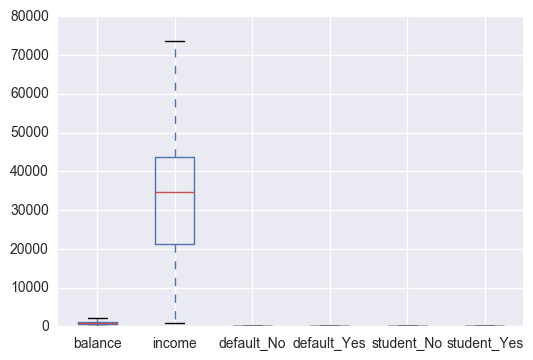

In [6]:
df_final.boxplot()
plt.show

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

Area under the ROC curve : 0.941063


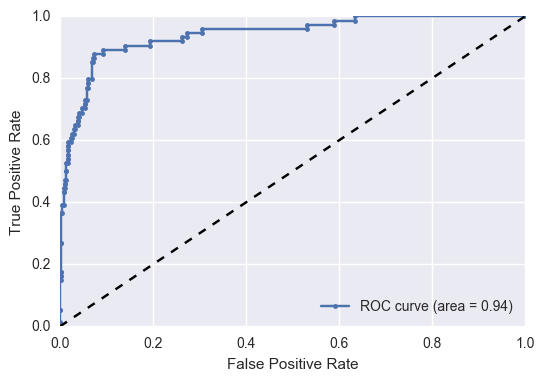

In [7]:
# 
X = df_final.drop(['default_No','default_Yes','student_No','student_Yes'], 1)
y = df_final.default_Yes

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    split = int(n_samples/5)
    X_train, X_test = X[split:], X[:split]
    y_train, y_test = y[split:], y[:split]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
   
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)


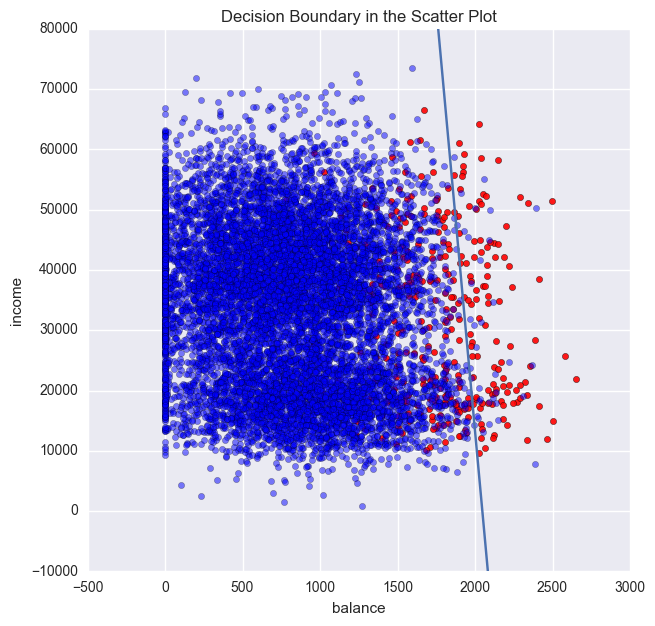

In [22]:
X = df_final[['balance', 'income']]
y = df_final.default_Yes

from sklearn.model_selection import train_test_split

X_train, X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)
coef = clf.coef_

#scatter plot and decision boundary
fig = plt.figure(figsize=(7,7))
plt.scatter(x=df_y['balance'], y=df_y['income'], c='r', label='default_yes', alpha=0.9)
plt.scatter(x=df_n['balance'], y=df_n['income'], c='b', label='default_no', alpha=0.5)   
plt.xlabel('balance')
plt.ylabel('income')

b = clf.intercept_
w = clf.coef_[0]
axes = plt.gca()
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()

x = np.arange(xmin, xmax, 1)
y = (b + w[0] * x) / -w[1]

plt.plot(x, y)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title('Decision Boundary in the Scatter Plot')


5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

Area under the ROC curve : 0.970738


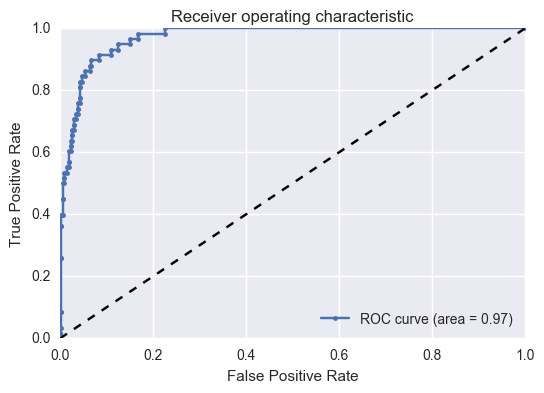

In [19]:
from sklearn.model_selection import train_test_split
y = df_final['default_Yes']
X = df_final[['balance','income','student_Yes','student_No']]
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % (roc_auc))
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)



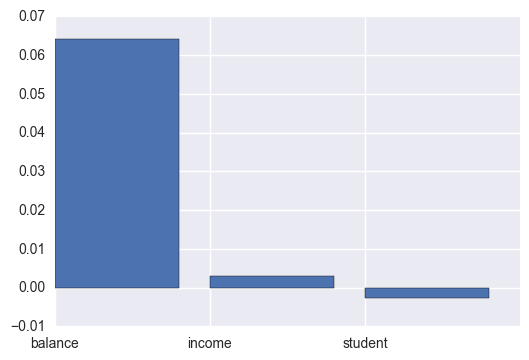

In [33]:
X = df_final[['balance', 'income', 'student_Yes']]
y = df_final.default_Yes

scaler = StandardScaler()
X = X.as_matrix().astype(np.float)
X = scaler.fit_transform(X)

# Split the targets into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

alphas = np.logspace(-8,1,100)
scores = []
for alpha in alphas:
    regr = Ridge(alpha=alpha)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    scores.append(regr.score(X_test,y_test))
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(3), regr.coef_)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('balance', 'income', 'student'))

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

Area under the ROC curve : 0.963918
Area under the ROC curve : 0.990434
Area under the ROC curve : 0.979329
Area under the ROC curve : 0.963636
Area under the ROC curve : 0.976041


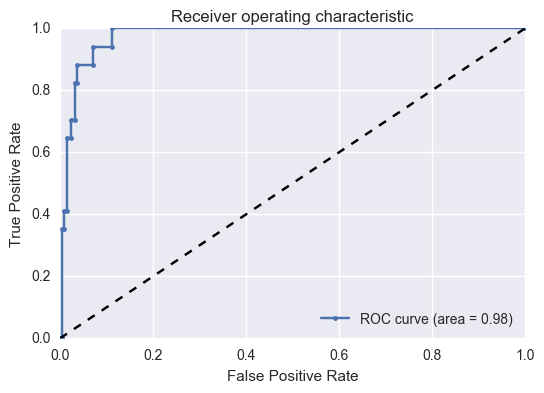

In [20]:
# Cross validation 5
X = df_final[['balance', 'income']]
y = df_final.default_Yes
folds = [10, 20, 30, 40, 50]
for n in folds:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=n)
    clf = LogisticRegression(penalty='l1', C=100)
    clf.fit(X_train, y_train)
    fpr,tpr,roc_auc, thresholds = generate_auc(X_test,y_test,LogisticRegression,C=100,penalty='l1')
generate_ROCplot(fpr,tpr,'LR',roc_auc)

The performance is pretty well because it is range from 0.96-0.99

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [13]:
from sklearn.tree import DecisionTreeClassifier
from __future__ import print_function
import os
import subprocess
from IPython.display import Image
import numpy.random as nprnd
from PIL import Image, ImageFilter
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import pydotplus

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus

def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
 




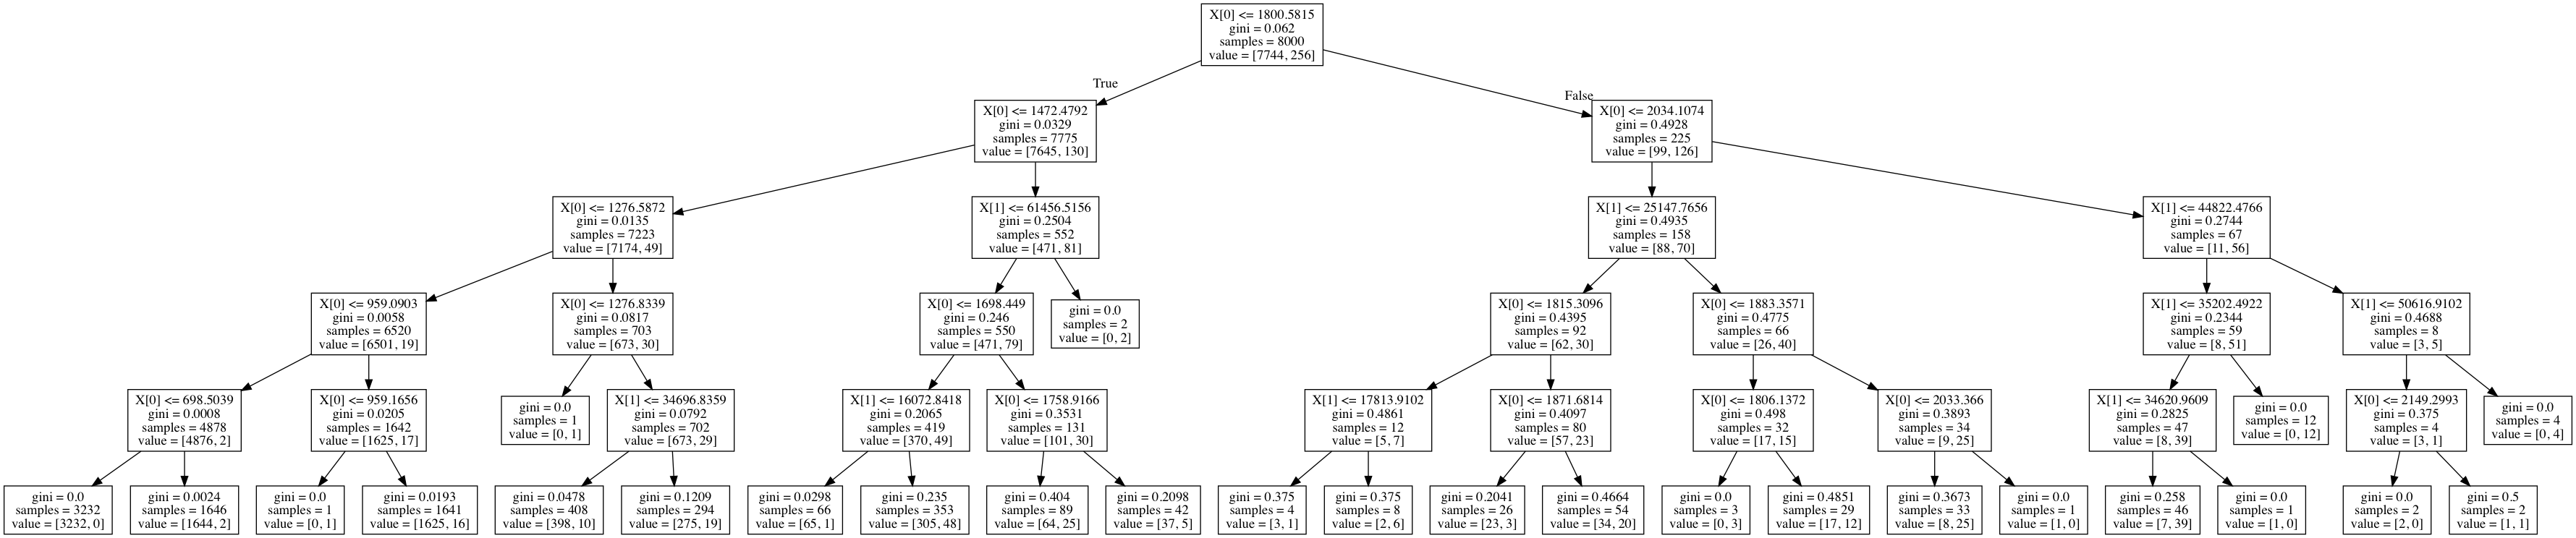

In [14]:
dt =DecisionTreeClassifier(max_depth=5)

X = df_final[['balance', 'income']]
y = df_final.default_Yes
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit regression model
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

# Predict
y = clf.predict(X_test)

dt=DecisionTreeClassifier(max_depth=5)
visualize_tree(clf, feature_names=['x'])

dot_data=export_graphviz(clf, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

8) Find the optimal decision tree depth and compute the AUC ROC. 

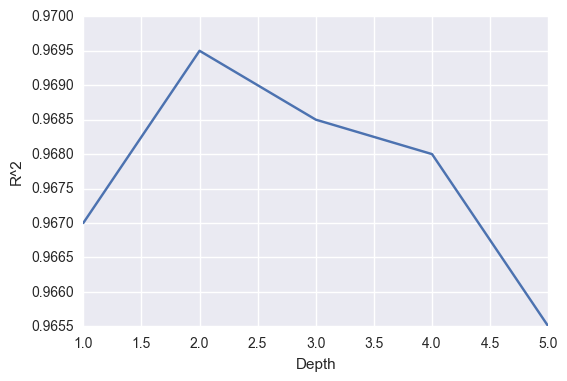

In [24]:
from sklearn.model_selection import train_test_split
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,6)
for n in depths:
    regr = DecisionTreeClassifier(max_depth=n)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[np.argmax(scores)]

Thus, we can observe that the optimal decision tree depth is 2.

Area under the ROC curve : 0.954999


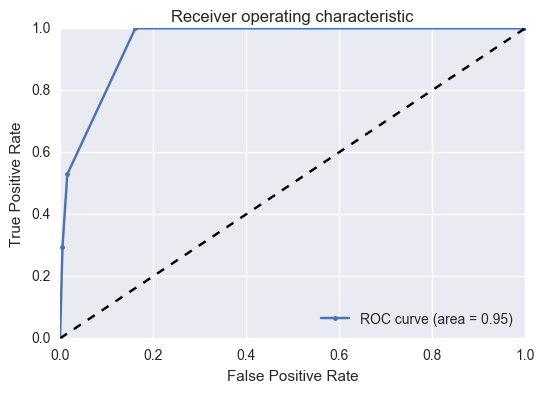

In [26]:
# Plot area under the ROC curve

fpr,tpr,roc_auc, thresholds = generate_auc(X_test,y_test,DecisionTreeClassifier,max_depth=2)
     
generate_ROCplot(fpr,tpr,'LR',roc_auc)